### Part 0: Environment and package dependencies

In [192]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import scipy.stats as stats 
import time
from datetime import datetime, timedelta
from ast import literal_eval
import configparser
import requests
import csv
import kaggle
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
import plotly.figure_factory as ff
from plotly.subplots import make_subplots
from plotly.offline import plot, iplot, init_notebook_mode
from matplotlib.colors import LinearSegmentedColormap
from IPython.display import display

# Model training and tuning
import h2o

# Random Forest
from h2o.estimators import H2ORandomForestEstimator

# XGBoost
from h2o.estimators import H2OXGBoostEstimator

# Grid
from h2o.grid.grid_search import H2OGridSearch

from sklearn.metrics import precision_recall_curve
from sklearn.calibration import calibration_curve

In [193]:
# Import data from known path, adapt as need the path
userhome = os.path.expanduser('~')
df = pd.read_csv(userhome + r'/Documents/Repos/heart-failure-prediction/data/raw/heart.csv', sep=',')

In [194]:
# Import directly from Kaggle with API call into whatever current directory is at notebook start-up. 
# It will require that users have kaggle.json token generated and downloaded beforehand/
kaggle.api.authenticate()

kaggle.api.dataset_download_files('fedesoriano/heart-failure-prediction', path=os.getcwd(), unzip=True)

df = pd.read_csv(os.path.join(os.getcwd(),'heart.csv'), sep=',')

### Part 1: Summary Data Exploration

In [195]:
# Data preview
df.head()

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
0,40,M,ATA,140,289,0,Normal,172,N,0.0,Up,0
1,49,F,NAP,160,180,0,Normal,156,N,1.0,Flat,1
2,37,M,ATA,130,283,0,ST,98,N,0.0,Up,0
3,48,F,ASY,138,214,0,Normal,108,Y,1.5,Flat,1
4,54,M,NAP,150,195,0,Normal,122,N,0.0,Up,0


In [196]:
# Inspect data types and convert case by case
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 918 entries, 0 to 917
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Age             918 non-null    int64  
 1   Sex             918 non-null    object 
 2   ChestPainType   918 non-null    object 
 3   RestingBP       918 non-null    int64  
 4   Cholesterol     918 non-null    int64  
 5   FastingBS       918 non-null    int64  
 6   RestingECG      918 non-null    object 
 7   MaxHR           918 non-null    int64  
 8   ExerciseAngina  918 non-null    object 
 9   Oldpeak         918 non-null    float64
 10  ST_Slope        918 non-null    object 
 11  HeartDisease    918 non-null    int64  
dtypes: float64(1), int64(6), object(5)
memory usage: 86.2+ KB


#### Notably, convert FastingBS and HeartDisease which are binary variables [0,1] to category to:
* avoid inclusion in Pearson's correlation calculations which are meant for continous variables
* include the binary variables alongside the other multi-levelled categoricals in the dataset in the Cramer's V calculation
* avoid a wrongful inclusion in standardisation or normalisation methods that are benefiting models that don't assume any distribution like clustering or Neural Networks

In [197]:
numeric_cols = ['Age','RestingBP','Cholesterol','MaxHR','Oldpeak']
df[numeric_cols] = df[numeric_cols].apply(pd.to_numeric, errors='coerce')

categorical_cols = ['Sex','ChestPainType','FastingBS','RestingECG','ExerciseAngina','ST_Slope','HeartDisease']
df[categorical_cols] = df[categorical_cols].astype('category')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 918 entries, 0 to 917
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype   
---  ------          --------------  -----   
 0   Age             918 non-null    int64   
 1   Sex             918 non-null    category
 2   ChestPainType   918 non-null    category
 3   RestingBP       918 non-null    int64   
 4   Cholesterol     918 non-null    int64   
 5   FastingBS       918 non-null    category
 6   RestingECG      918 non-null    category
 7   MaxHR           918 non-null    int64   
 8   ExerciseAngina  918 non-null    category
 9   Oldpeak         918 non-null    float64 
 10  ST_Slope        918 non-null    category
 11  HeartDisease    918 non-null    category
dtypes: category(7), float64(1), int64(4)
memory usage: 43.0 KB


In [198]:
# Provide summary statistics of categorical data
df.select_dtypes(include=['category']).describe()

,Sex,ChestPainType,FastingBS,RestingECG,ExerciseAngina,ST_Slope,HeartDisease
count,918,918,918,918,918,918,918
unique,2,4,2,3,2,3,2
top,M,ASY,0,Normal,N,Flat,1
freq,725,496,704,552,547,460,508


In [199]:
# Provide summary statistics of numerical data
df.describe().transpose()


,count,mean,std,min,25%,50%,75%,max
Age,918.0,53.510893,9.432617,28.0,47.00,54.0,60.0,77.0
RestingBP,918.0,132.396514,18.514154,0.0,120.00,130.0,140.0,200.0
Cholesterol,918.0,198.799564,109.384145,0.0,173.25,223.0,267.0,603.0
MaxHR,918.0,136.809368,25.460334,60.0,120.00,138.0,156.0,202.0
Oldpeak,918.0,0.887364,1.066570,-2.6,0.00,0.6,1.5,6.2


In [200]:
# Check for missing values
df.isna().sum()

Age               0
Sex               0
ChestPainType     0
RestingBP         0
Cholesterol       0
FastingBS         0
RestingECG        0
MaxHR             0
ExerciseAngina    0
Oldpeak           0
ST_Slope          0
HeartDisease      0
dtype: int64

In [201]:
# Check unique values in each column
dict = {}
for i in list(df.columns):
    dict[i] = df[i].value_counts().shape[0]

pd.DataFrame(dict,index=["unique count"]).transpose()

,unique count
Age,50
Sex,2
ChestPainType,4
RestingBP,67
Cholesterol,222
FastingBS,2
RestingECG,3
MaxHR,119
ExerciseAngina,2
Oldpeak,53


In [202]:
# Check number of faulty Cholesterol recordings 
print(len(df[df['Cholesterol']==0]))

# Perform imputation with median for Cholesterol
impute_median = df[df['Cholesterol'] != 0]['Cholesterol'].median()
df.loc[df['Cholesterol'] == 0, 'Cholesterol'] = impute_median

172


[Text(0, 0, 'Heart Disease'), Text(1, 0, 'Normal')]

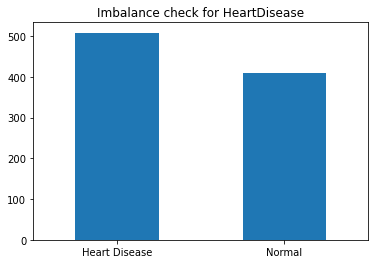

In [274]:
# Check label imbalance
fig, ax = plt.subplots()
df['HeartDisease'].value_counts().plot(kind='bar', ax=ax)
plt.title('Imbalance check for HeartDisease')
labels = [item.get_text() for item in ax.get_xticklabels()]
labels[0] = 'Heart Disease' 
labels[1] = 'Normal'
ax.set_xticklabels(labels, rotation=0, ha='center')


In [204]:
# Data details saved
data_dictionary = {
    'Age': 'age of the patient [years]',
    'Sex': 'sex of the patient [M: Male, F: Female]',
    'ChestPainType': 'chest pain type [TA: Typical Angina, ATA: Atypical Angina, NAP: Non-Anginal Pain, ASY: Asymptomatic]',
    'RestingBP': 'resting blood pressure [mm Hg]',
    'Cholesterol': 'serum cholesterol [mm/dl]',
    'FastingBS': 'fasting blood sugar [1: if FastingBS > 120 mg/dl, 0: otherwise]',
    'RestingECG': 'resting electrocardiogram results [Normal: Normal, ST: having ST-T wave abnormality (T wave inversions and/or ST elevation or depression of > 0.05 mV), LVH: showing probable or definite left ventricular hypertrophy by Estes criteria]',
    'MaxHR': 'maximum heart rate achieved [Numeric value between 60 and 202]',
    'ExerciseAngina': 'exercise-induced angina [Y: Yes, N: No]',
    'Oldpeak': 'oldpeak = ST [Numeric value measured in depression]',
    'ST_Slope': 'the slope of the peak exercise ST segment [Up: upsloping, Flat: flat, Down: downsloping]',
    'HeartDisease': 'output class [1: heart disease, 0: Normal]'
}

In [205]:
data_dictionary

{'Age': 'age of the patient [years]',
 'Sex': 'sex of the patient [M: Male, F: Female]',
 'ChestPainType': 'chest pain type [TA: Typical Angina, ATA: Atypical Angina, NAP: Non-Anginal Pain, ASY: Asymptomatic]',
 'RestingBP': 'resting blood pressure [mm Hg]',
 'Cholesterol': 'serum cholesterol [mm/dl]',
 'FastingBS': 'fasting blood sugar [1: if FastingBS > 120 mg/dl, 0: otherwise]',
 'RestingECG': 'resting electrocardiogram results [Normal: Normal, ST: having ST-T wave abnormality (T wave inversions and/or ST elevation or depression of > 0.05 mV), LVH: showing probable or definite left ventricular hypertrophy by Estes criteria]',
 'MaxHR': 'maximum heart rate achieved [Numeric value between 60 and 202]',
 'ExerciseAngina': 'exercise-induced angina [Y: Yes, N: No]',
 'Oldpeak': 'oldpeak = ST [Numeric value measured in depression]',
 'ST_Slope': 'the slope of the peak exercise ST segment [Up: upsloping, Flat: flat, Down: downsloping]',
 'HeartDisease': 'output class [1: heart disease, 0: 

### Part 2: Visual Data Exploration

In [206]:
# Explore correlations
temp_df = df
temp_df['HeartDisease'] = pd.to_numeric(temp_df['HeartDisease'])
corr = temp_df.corr()
corr.style.background_gradient(cmap='coolwarm', axis=None).set_precision(2)

,Age,RestingBP,Cholesterol,MaxHR,Oldpeak,HeartDisease
Age,1.00,0.25,0.05,-0.38,0.26,0.28
RestingBP,0.25,1.00,0.08,-0.11,0.16,0.11
Cholesterol,0.05,0.08,1.00,-0.00,0.05,0.08
MaxHR,-0.38,-0.11,-0.00,1.00,-0.16,-0.40
Oldpeak,0.26,0.16,0.05,-0.16,1.00,0.40
HeartDisease,0.28,0.11,0.08,-0.40,0.40,1.00


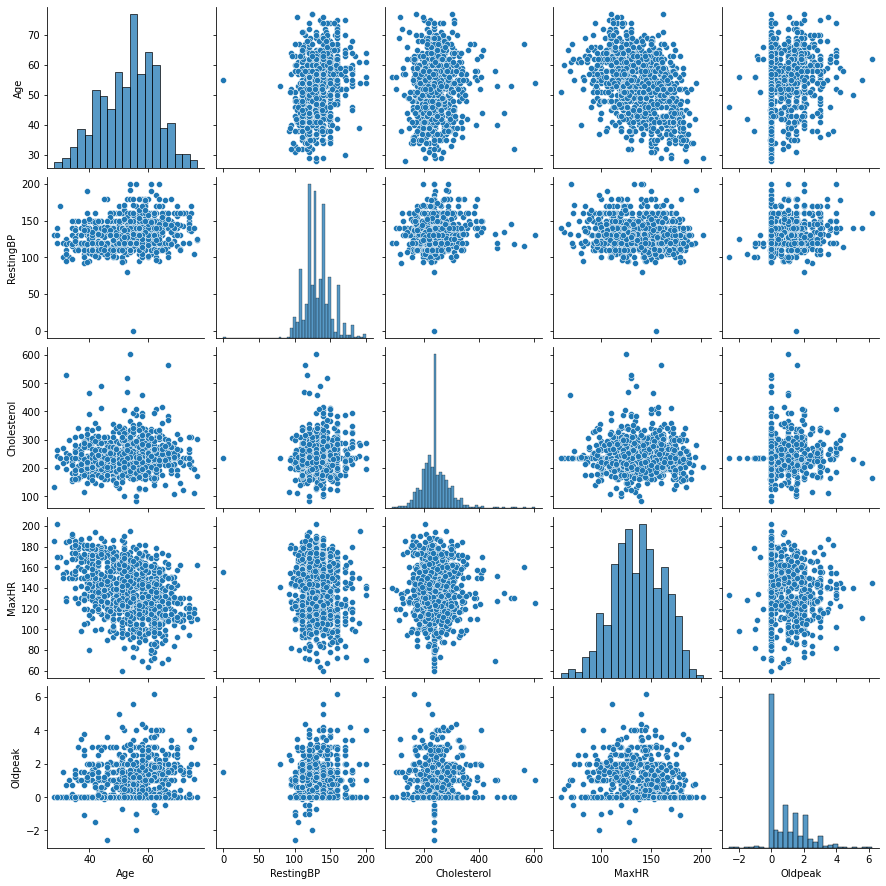

In [207]:
# Create Pair Plots of numerical data
sns.pairplot(temp_df[numeric_cols])

In [239]:
# Initialize H2O run
import h2o
localH2O = h2o.init(ip = "localhost",
port = 54321,
max_mem_size="16G",
nthreads = -1)

Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
  Java Version: openjdk version "11.0.9.1" 2020-11-04 LTS; OpenJDK Runtime Environment Zulu11.43+55-CA (build 11.0.9.1+1-LTS); OpenJDK 64-Bit Server VM Zulu11.43+55-CA (build 11.0.9.1+1-LTS, mixed mode)
  Starting server from /Users/adumitru/opt/anaconda3/envs/ds2_mona/lib/python3.7/site-packages/h2o/backend/bin/h2o.jar
  Ice root: /var/folders/nw/1hz_hyy52r7cskb6z_n5mzhm0000gn/T/tmpikg3dhbq
  JVM stdout: /var/folders/nw/1hz_hyy52r7cskb6z_n5mzhm0000gn/T/tmpikg3dhbq/h2o_adumitru_started_from_python.out
  JVM stderr: /var/folders/nw/1hz_hyy52r7cskb6z_n5mzhm0000gn/T/tmpikg3dhbq/h2o_adumitru_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,02 secs
H2O_cluster_timezone:,Europe/London
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.34.0.7
H2O_cluster_version_age:,1 month and 11 days
H2O_cluster_name:,H2O_from_python_adumitru_63crci
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,16 Gb
H2O_cluster_total_cores:,8
H2O_cluster_allowed_cores:,8
H2O_cluster_status:,"locked, healthy"


In [240]:
hdf = h2o.H2OFrame(df,
            column_types = {'Age': 'int',
                            'Sex': 'enum',
                            'ChestPainType': 'enum',
                            'RestingBP': 'int',   
                            'Cholesterol': 'int',
                            'FastingBS': 'enum',
                            'RestingECG': 'enum',
                            'MaxHR': 'int',
                            'ExerciseAngina': 'enum',
                            'Oldpeak': 'real',
                            'ST_Slope': 'enum',
                            'HeartDisease': 'enum'
                            })

Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%


In [241]:
# Check H2O dataframe 
hdf.summary()

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
type,int,enum,enum,int,int,enum,enum,int,enum,real,enum,enum
mins,28.0,,,0.0,85.0,,,60.0,,-2.6,,
mean,53.51089324618732,,,132.39651416121995,243.2047930283225,,,136.8093681917212,,0.8873638344226575,,
maxs,77.0,,,200.0,603.0,,,202.0,,6.2,,
sigma,9.43261650673202,,,18.514154119907804,53.401296539452275,,,25.46033413825029,,1.0665701510493264,,
zeros,0,,,1,0,,,0,,368,,
missing,0,0,0,0,0,0,0,0,0,0,0,0
0,40.0,M,ATA,140.0,289.0,0,Normal,172.0,N,0.0,Up,0
1,49.0,F,NAP,160.0,180.0,0,Normal,156.0,N,1.0,Flat,1
2,37.0,M,ATA,130.0,283.0,0,ST,98.0,N,0.0,Up,0


In [242]:
# Recheck label distribution
hdf['HeartDisease'].table()

HeartDisease,Count
0,410
1,508


In [243]:
# Set response variable
response_col = "HeartDisease"

# Set predictors (generic formulation, other id columns or redundant features could be used in this exclusion method)
predictors = hdf.columns
predictors = [elements for elements in predictors if elements not in (response_col)]

In [244]:
# Split train and test 70/30
train, test = hdf.split_frame(ratios=[.7])

In [245]:
print("Train discrete distribution between label categories.")
print(train['HeartDisease'].table())
print("Test discrete distribution between label categories.")
print(test['HeartDisease'].table())

Train discrete distribution between label categories.


HeartDisease,Count
0,303
1,343



Test discrete distribution between label categories.


HeartDisease,Count
0,107
1,165


### Grid Search
The Random Forests and XGBoost models are hyper-parameter tuned using H2O's grid process. The best model is chosen based on ascending ranking of logloss (i.e. smaller logloss on cross-validation is better). The best model per model type is then used for final comparison on the test set in choosing the winning model for the article.

### Distributed Random Forests (DRF)

In [246]:
start_time = time.time()

drf_grid_id_base = 'model_drf_'+ datetime.today().strftime('%Y%m%d')

hyper_parameters = {'ntrees': [50,100,200],
                    'max_depth': list(range(9,21)),
                    'sample_rate': [i * 0.05 for i in range(4,20)],
                    'min_rows': [5,10,20,50,100],
                    'nbins_cats': [2**(i*1) for i in range(4,11)],
                    'col_sample_rate_change_per_level': [.3, .7, .8, 1],
                    'col_sample_rate_per_tree': [i * 0.01 for i in range(90, 100)],
                    'min_split_improvement': [0, 1e-8, 1e-6, 1e-4],
                    'histogram_type': ["UniformAdaptive","QuantilesGlobal","RoundRobin"]}

search_criteria = {'strategy': 'RandomDiscrete',
                   'max_models': 50,
                   'stopping_metric': 'logloss',
                   'stopping_tolerance': 0.01,
                   'stopping_rounds': 3,
                   'seed': 101}

drf_grid = H2OGridSearch(model = H2ORandomForestEstimator,
                         grid_id = drf_grid_id_base,
                         hyper_params = hyper_parameters,
                         search_criteria = search_criteria)

drf_grid.train(x = predictors,
               y = response_col,
               training_frame = train,
               nfolds = 3,
               fold_assignment = 'Stratified')

print("--- %s seconds ---" % round((time.time() - start_time),2))

drf Grid Build progress: |███████████████████████████████████████████████████████| (done) 100%
--- 93.14 seconds ---


### DRF Evaluation

In [ ]:
# Save top DRF from the grid
drf_gridperf = drf_grid.get_grid(sort_by='logloss', decreasing=False)

# Isolate best model from the DRF grid. The best model is chosen by smallest logloss on cross-validation.
best_drf_temp = drf_gridperf.models[0]
model_path = os.path.join(os.getcwd(), 'best_drf')

# Uncomment save_mojo if new model is retrained
# best_drf_temp.save_mojo(model_path)


In [248]:
# Load saved model
model_path = os.path.join(os.getcwd(), 'best_drf')
best_drf = h2o.import_mojo(model_path)

generic Model Build progress: |██████████████████████████████████████████████████| (done) 100%
Model Details
H2OGenericEstimator :  Import MOJO Model
Model Key:  best_drf


Model Summary: 


,,number_of_trees,number_of_internal_trees,model_size_in_bytes,min_depth,max_depth,mean_depth,min_leaves,max_leaves,mean_leaves
0,,200.0,200.0,157672.0,8.0,12.0,10.295,47.0,71.0,58.035




ModelMetricsBinomialGeneric: generic
** Reported on train data. **

MSE: 0.10200124839687848
RMSE: 0.31937634288857164
LogLoss: 0.48445462409678913
Mean Per-Class Error: 0.12681734645767784
AUC: 0.925949446256579
AUCPR: 0.9053778145380971
Gini: 0.8518988925131581

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.4428413510322571: 


,,0,1,Error,Rate
0,0,250.0,53.0,0.1749,(53.0/303.0)
1,1,27.0,316.0,0.0787,(27.0/343.0)
2,Total,277.0,369.0,0.1238,(80.0/646.0)



Maximum Metrics: Maximum metrics at their respective thresholds


,metric,threshold,value,idx
0,max f1,0.442841,0.887640,227.0
1,max f2,0.296429,0.926857,264.0
2,max f0point5,0.675510,0.876903,164.0
3,max accuracy,0.442841,0.876161,227.0
4,max precision,0.971429,0.947368,16.0
5,max recall,0.014087,1.000000,387.0
6,max specificity,1.000000,0.990099,0.0
7,max absolute_mcc,0.442841,0.752604,227.0
8,max min_per_class_accuracy,0.577778,0.851485,199.0
9,max mean_per_class_accuracy,0.442841,0.873183,227.0



Gains/Lift Table: Avg response rate: 53.10 %, avg score: 53.19 %


,group,cumulative_data_fraction,lower_threshold,lift,cumulative_lift,response_rate,score,cumulative_response_rate,cumulative_score,capture_rate,cumulative_capture_rate,gain,cumulative_gain,kolmogorov_smirnov
0,1,0.038700,1.000000,1.657376,1.657376,0.880000,1.000000,0.880000,1.000000,0.064140,0.064140,65.737609,65.737609,0.054239
1,2,0.040248,0.993298,1.883382,1.666069,1.000000,0.996795,0.884615,0.999877,0.002915,0.067055,88.338192,66.606863,0.057154
2,3,0.051084,0.985714,1.883382,1.712165,1.000000,0.988335,0.909091,0.997429,0.020408,0.087464,88.338192,71.216539,0.077563
3,4,0.102167,0.966667,1.769238,1.740701,0.939394,0.975405,0.924242,0.986417,0.090379,0.177843,76.923757,74.070148,0.161341
4,5,0.150155,0.942865,1.761873,1.747468,0.935484,0.955216,0.927835,0.976445,0.084548,0.262391,76.187341,74.746776,0.239288
5,6,0.201238,0.922500,1.769238,1.752994,0.939394,0.932465,0.930769,0.965281,0.090379,0.352770,76.923757,75.299394,0.323067
6,7,0.300310,0.858288,1.795098,1.766884,0.953125,0.890518,0.938144,0.940617,0.177843,0.530612,79.509840,76.688407,0.491008
7,8,0.400929,0.751923,1.680556,1.745219,0.892308,0.809337,0.926641,0.907670,0.169096,0.699708,68.055618,74.521877,0.637002
8,9,0.500000,0.616941,1.265397,1.650146,0.671875,0.679601,0.876161,0.862480,0.125364,0.825073,26.539723,65.014577,0.693060
9,10,0.600619,0.408333,1.130029,1.563013,0.600000,0.505799,0.829897,0.802727,0.113703,0.938776,13.002915,56.301283,0.720954




ModelMetricsBinomialGeneric: generic
** Reported on cross-validation data. **

MSE: 0.10501879406153997
RMSE: 0.32406603348938
LogLoss: 0.34773631389128934
Mean Per-Class Error: 0.1403217581233342
AUC: 0.9285569956412552
AUCPR: 0.9146713724333448
Gini: 0.8571139912825103

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.5215551186352968: 


,,0,1,Error,Rate
0,0,248.0,55.0,0.1815,(55.0/303.0)
1,1,34.0,309.0,0.0991,(34.0/343.0)
2,Total,282.0,364.0,0.1378,(89.0/646.0)



Maximum Metrics: Maximum metrics at their respective thresholds


,metric,threshold,value,idx
0,max f1,0.521555,0.874116,213.0
1,max f2,0.280305,0.921849,283.0
2,max f0point5,0.673296,0.890635,162.0
3,max accuracy,0.603351,0.862229,186.0
4,max precision,0.996595,1.000000,0.0
5,max recall,0.063895,1.000000,358.0
6,max specificity,0.996595,1.000000,0.0
7,max absolute_mcc,0.603351,0.724978,186.0
8,max min_per_class_accuracy,0.580900,0.861386,194.0
9,max mean_per_class_accuracy,0.603351,0.863142,186.0



Gains/Lift Table: Avg response rate: 53.10 %, avg score: 53.84 %


,group,cumulative_data_fraction,lower_threshold,lift,cumulative_lift,response_rate,score,cumulative_response_rate,cumulative_score,capture_rate,cumulative_capture_rate,gain,cumulative_gain,kolmogorov_smirnov
0,1,0.010836,0.990916,1.614327,1.614327,0.857143,0.993088,0.857143,0.993088,0.017493,0.017493,61.432736,61.432736,0.014192
1,2,0.020124,0.986428,1.883382,1.738506,1.000000,0.988684,0.923077,0.991056,0.017493,0.034985,88.338192,73.850639,0.031685
2,3,0.030960,0.981032,1.345273,1.600875,0.714286,0.984411,0.850000,0.988730,0.014577,0.049563,34.527280,60.087464,0.039662
3,4,0.040248,0.976902,1.883382,1.666069,1.000000,0.980124,0.884615,0.986744,0.017493,0.067055,88.338192,66.606863,0.057154
4,5,0.051084,0.971152,1.883382,1.712165,1.000000,0.974955,0.909091,0.984243,0.020408,0.087464,88.338192,71.216539,0.077563
5,6,0.100619,0.951121,1.824526,1.767481,0.968750,0.961002,0.938462,0.972802,0.090379,0.177843,82.452624,76.748150,0.164641
6,7,0.150155,0.926097,1.883382,1.805717,1.000000,0.938745,0.958763,0.961566,0.093294,0.271137,88.338192,80.571669,0.257936
7,8,0.201238,0.902228,1.826310,1.810944,0.969697,0.915553,0.961538,0.949886,0.093294,0.364431,82.630974,81.094416,0.347930
8,9,0.300310,0.840845,1.677387,1.766884,0.890625,0.871227,0.938144,0.923937,0.166181,0.530612,67.738703,76.688407,0.491008
9,10,0.400929,0.756013,1.709531,1.752491,0.907692,0.802333,0.930502,0.893418,0.172012,0.702624,70.953129,75.249052,0.643218




Cross-Validation Metrics Summary: 


,,mean,sd,cv_1_valid,cv_2_valid,cv_3_valid
0,accuracy,0.867486,0.032336,0.875622,0.894977,0.831858
1,auc,0.932200,0.032088,0.949349,0.952070,0.895182
2,err,0.132514,0.032336,0.124378,0.105023,0.168142
3,err_count,28.666666,8.144527,25.000000,23.000000,38.000000
4,f0point5,0.870514,0.047385,0.874786,0.915619,0.821138
5,f1,0.877058,0.030900,0.890830,0.898678,0.841667
6,f2,0.884358,0.022181,0.907473,0.882353,0.863248
7,lift_top_group,1.882608,0.077769,1.810811,1.871795,1.965217
8,logloss,0.346133,0.056102,0.313788,0.313697,0.410914
9,max_per_class_error,0.174066,0.044123,0.177778,0.128205,0.216216



Scoring History: 


,,timestamp,duration,number_of_trees,training_rmse,training_logloss,training_auc,training_pr_auc,training_lift,training_classification_error
0,,2022-02-02 06:08:12,1 min 1.829 sec,0.0,NaN,NaN,NaN,NaN,NaN,NaN
1,,2022-02-02 06:08:12,1 min 1.832 sec,1.0,0.334929,1.311230,0.913725,0.891943,1.726433,0.156250
2,,2022-02-02 06:08:12,1 min 1.836 sec,2.0,0.315957,0.286035,0.938329,0.951095,1.883382,0.145455
3,,2022-02-02 06:08:12,1 min 1.840 sec,3.0,0.343858,1.183059,0.914651,0.884066,1.732711,0.160000
4,,2022-02-02 06:08:12,1 min 1.844 sec,4.0,0.349620,1.309177,0.912245,0.882813,1.726433,0.161616
5,,2022-02-02 06:08:12,1 min 1.847 sec,5.0,0.330001,1.081721,0.923757,0.898663,1.745573,0.153226
6,,2022-02-02 06:08:12,1 min 1.851 sec,6.0,0.330629,1.218503,0.920532,0.896545,1.729636,0.141844
7,,2022-02-02 06:08:12,1 min 1.855 sec,7.0,0.330970,1.094385,0.920319,0.898626,1.741240,0.134146
8,,2022-02-02 06:08:12,1 min 1.858 sec,8.0,0.323881,1.154022,0.922273,0.898569,1.729006,0.127660
9,,2022-02-02 06:08:12,1 min 1.863 sec,9.0,0.320380,0.888662,0.928474,0.913313,1.775760,0.129032



See the whole table with table.as_data_frame()

Variable Importances: 


,variable,relative_importance,scaled_importance,percentage
0,ST_Slope,6016.955566,1.000000,0.281060
1,ChestPainType,3682.854492,0.612079,0.172031
2,Oldpeak,2838.589600,0.471765,0.132594
3,ExerciseAngina,2725.222168,0.452924,0.127299
4,MaxHR,1782.625122,0.296267,0.083269
5,Age,1053.209106,0.175040,0.049197
6,Sex,979.595520,0.162806,0.045758
7,FastingBS,745.149963,0.123842,0.034807
8,Cholesterol,684.195068,0.113711,0.031960
9,RestingBP,542.064819,0.090090,0.025321


In [249]:
# Check performance metrics on test set
best_drf.model_performance(test)


ModelMetricsBinomial: generic
** Reported on test data. **

MSE: 0.11371205007244833
RMSE: 0.3372121736717824
LogLoss: 0.3657179336341902
Mean Per-Class Error: 0.14497309544038517
AUC: 0.9147550269045596
AUCPR: 0.9359887647576673
Gini: 0.8295100538091191

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.42260900910943744: 


,,0,1,Error,Rate
0,0,87.0,20.0,0.1869,(20.0/107.0)
1,1,17.0,148.0,0.103,(17.0/165.0)
2,Total,104.0,168.0,0.136,(37.0/272.0)



Maximum Metrics: Maximum metrics at their respective thresholds


,metric,threshold,value,idx
0,max f1,0.422609,0.888889,167.0
1,max f2,0.203276,0.930636,204.0
2,max f0point5,0.568057,0.891678,147.0
3,max accuracy,0.422609,0.863971,167.0
4,max precision,0.994427,1.000000,0.0
5,max recall,0.026126,1.000000,252.0
6,max specificity,0.994427,1.000000,0.0
7,max absolute_mcc,0.422609,0.713763,167.0
8,max min_per_class_accuracy,0.514501,0.841121,155.0
9,max mean_per_class_accuracy,0.422609,0.855027,167.0


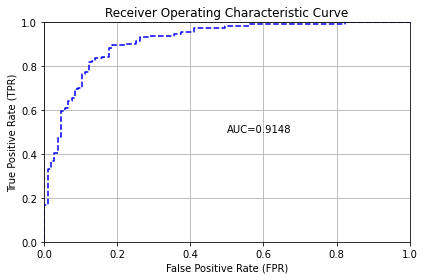

([0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.009345794392523364,
  0.009345794392523364,
  0.009345794392523364,
  0.009345794392523364,
  0.009345794392523364,
  0.009345794392523364,
  0.009345794392523364,
  0.009345794392523364,
  0.009345794392523364,
  0.009345794392523364,
  0.009345794392523364,
  0.009345794392523364,
  0.009345794392523364,
  0.009345794392523364,
  0.009345794392523364,
  0.009345794392523364,
  0.009345794392523364,
  0.009345794392523364,
  0.009345794392523364,
  0.009345794392523364,
  0.009345794392523364,
  0.009345794392523364,
  0.009345794392523364,
  0.009345794392523364,
  0.009345794392523364,
  0.009345794392523364,
  0.009345794392523364,
  0.009345794392523364,
  0.018691588785046728,
  0.018691588785046728,
  0.018691588785046728,
  0.018691588785046728,
  0.018691588785046728,
  0.01869158

In [250]:
# Plot ROC Curve
performance = best_drf.model_performance(test)
performance.plot()

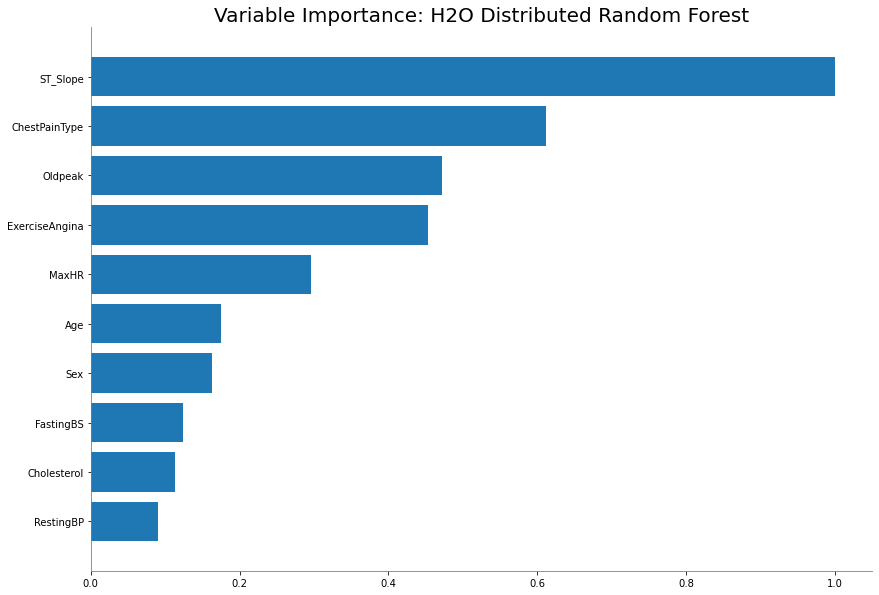

<Figure size 432x288 with 0 Axes>

In [254]:
# Plot Variable Importance for trained DRF, the loaded MOJO doesn't retain variable importance.
# best_drf.varimp_plot()
best_drf_temp.varimp_plot()

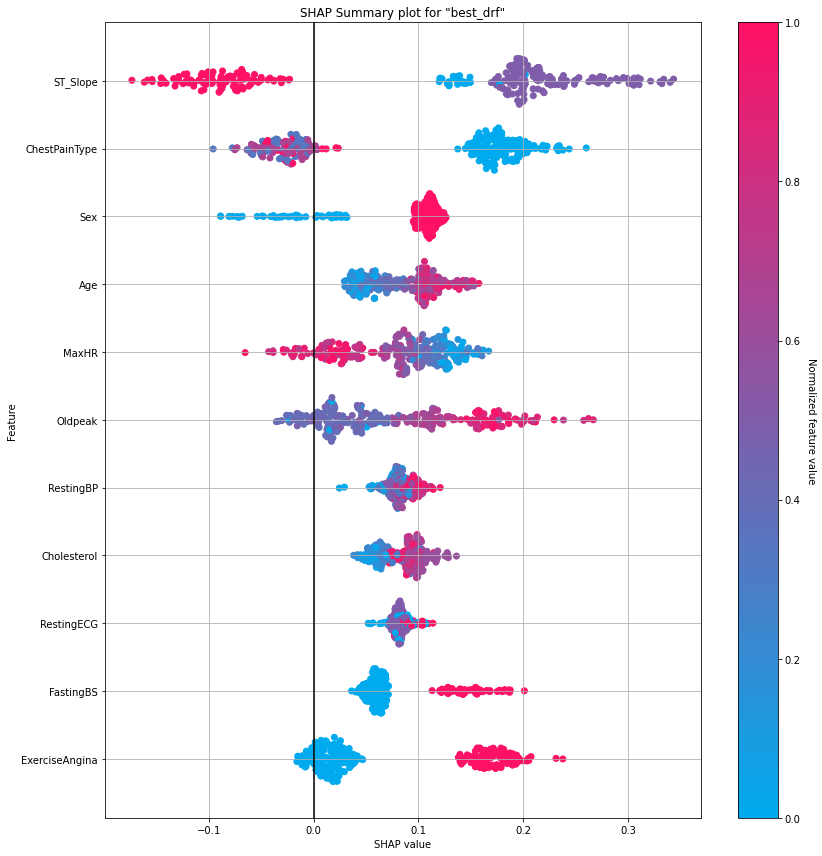

In [252]:
# Plot SHAP summary for the entire test set
best_drf.shap_summary_plot(test)

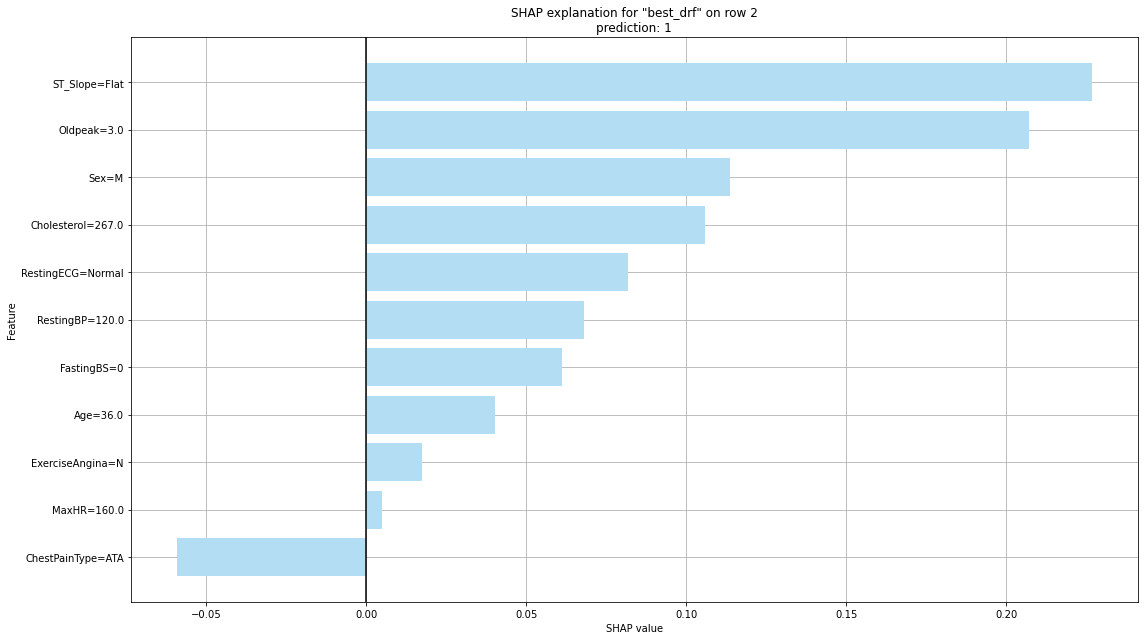

In [253]:
# Isolate prediction and contribution of individual features
shapley_plot = best_drf.shap_explain_row_plot(test, row_index=2)

## XGBoost

In [255]:
start_time = time.time()

xgb_grid_id_base = 'model_xgb_'+ datetime.today().strftime('%Y%m%d')

hyper_parameters = {'ntrees': [50,100,200],
                    'learn_rate': [i * 0.01 for i in range(5,11)],
                    'max_depth': list(range(9,21)),
                    'sample_rate': [i * 0.05 for i in range(4,20)],
                    'min_rows': [5,10,20,50,100],
                    'col_sample_rate': [i * 0.05 for i in range(4,20)],
                    'col_sample_rate_per_tree': [i * 0.01 for i in range(90, 100)],
                    'min_split_improvement': [0, 1e-8, 1e-6, 1e-4]}

search_criteria = {'strategy': 'RandomDiscrete',
                   'max_models': 50,
                   'stopping_metric': 'logloss',
                   'stopping_tolerance': 0.01,
                   'stopping_rounds': 3,
                   'seed': 101}

xgb_grid = H2OGridSearch(model = H2OXGBoostEstimator,
                         grid_id = xgb_grid_id_base,
                         hyper_params = hyper_parameters,
                         search_criteria = search_criteria)

xgb_grid.train(x = predictors,
               y = response_col,
               training_frame = train,
               nfolds = 3,
               fold_assignment = 'Stratified')

print("--- %s seconds ---" % round((time.time() - start_time),2))

xgboost Grid Build progress: |███████████████████████████████████████████████████| (done) 100%
--- 230.57 seconds ---


## XGBoost Evaluation

In [258]:
# Save top XGBoost model from the grid
xgb_gridperf = xgb_grid.get_grid(sort_by='logloss', decreasing=False)

# Isolate best model from the XGBoost grid. The best model is chosen by smallest logloss on cross-validation.
best_xgb_temp = xgb_grid.models[0]
model_path_xgb = os.path.join(os.getcwd(), 'best_xgb')

# Uncomment save_mojo if new model is retrained. Might need deleteing old model.
# best_xgb_temp.save_mojo(model_path_xgb)

'/Users/adumitru/Documents/Repos/heart-failure-prediction/best_xgb/model_xgb_20220202_model_50.zip'

In [259]:
# Load saved model
model_path_xgb = os.path.join(os.getcwd(), 'best_xgb')
best_xgb = h2o.import_mojo(model_path_xgb)

generic Model Build progress: |██████████████████████████████████████████████████| (done) 100%
Model Details
H2OGenericEstimator :  Import MOJO Model
Model Key:  best_xgb


Model Summary: 


,,number_of_trees
0,,200.0




ModelMetricsBinomialGeneric: generic
** Reported on train data. **

MSE: 0.061973225542279804
RMSE: 0.24894422174912959
LogLoss: 0.21656128795992313
Mean Per-Class Error: 0.06818116213953757
AUC: 0.973241347458361
AUCPR: 0.9744389523903636
Gini: 0.946482694916722

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.5696896910667419: 


,,0,1,Error,Rate
0,0,282.0,21.0,0.0693,(21.0/303.0)
1,1,23.0,320.0,0.0671,(23.0/343.0)
2,Total,305.0,341.0,0.0681,(44.0/646.0)



Maximum Metrics: Maximum metrics at their respective thresholds


,metric,threshold,value,idx
0,max f1,0.569690,0.935673,207.0
1,max f2,0.236174,0.948761,263.0
2,max f0point5,0.577372,0.940272,203.0
3,max accuracy,0.577372,0.931889,203.0
4,max precision,0.997468,1.000000,0.0
5,max recall,0.087224,1.000000,314.0
6,max specificity,0.997468,1.000000,0.0
7,max absolute_mcc,0.577372,0.863560,203.0
8,max min_per_class_accuracy,0.569690,0.930693,207.0
9,max mean_per_class_accuracy,0.577372,0.932204,203.0



Gains/Lift Table: Avg response rate: 53.10 %, avg score: 53.16 %


,group,cumulative_data_fraction,lower_threshold,lift,cumulative_lift,response_rate,score,cumulative_response_rate,cumulative_score,capture_rate,cumulative_capture_rate,gain,cumulative_gain,kolmogorov_smirnov
0,1,0.010836,0.993269,1.883382,1.883382,1.000000,0.995369,1.000000,0.995369,0.020408,0.020408,88.338192,88.338192,0.020408
1,2,0.021672,0.991260,1.883382,1.883382,1.000000,0.992131,1.000000,0.993750,0.020408,0.040816,88.338192,88.338192,0.040816
2,3,0.030960,0.990179,1.883382,1.883382,1.000000,0.990673,1.000000,0.992827,0.017493,0.058309,88.338192,88.338192,0.058309
3,4,0.041796,0.989574,1.883382,1.883382,1.000000,0.989858,1.000000,0.992057,0.020408,0.078717,88.338192,88.338192,0.078717
4,5,0.051084,0.988066,1.883382,1.883382,1.000000,0.988625,1.000000,0.991433,0.017493,0.096210,88.338192,88.338192,0.096210
5,6,0.100619,0.980525,1.883382,1.883382,1.000000,0.984566,1.000000,0.988052,0.093294,0.189504,88.338192,88.338192,0.189504
6,7,0.150155,0.974564,1.883382,1.883382,1.000000,0.977157,1.000000,0.984458,0.093294,0.282799,88.338192,88.338192,0.282799
7,8,0.201238,0.966643,1.769238,1.854407,0.939394,0.970319,0.984615,0.980869,0.090379,0.373178,76.923757,85.440682,0.366577
8,9,0.300310,0.927021,1.853954,1.854257,0.984375,0.946310,0.984536,0.969468,0.183673,0.556851,85.395408,85.425746,0.546950
9,10,0.400929,0.849579,1.767481,1.832480,0.938462,0.892922,0.972973,0.950257,0.177843,0.734694,76.748150,83.247971,0.711592




ModelMetricsBinomialGeneric: generic
** Reported on cross-validation data. **

MSE: 0.09659069906869715
RMSE: 0.31079044237025233
LogLoss: 0.3187278943106117
Mean Per-Class Error: 0.12574449864811554
AUC: 0.9357878936581704
AUCPR: 0.9318679596765695
Gini: 0.8715757873163408

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.3611832559108734: 


,,0,1,Error,Rate
0,0,248.0,55.0,0.1815,(55.0/303.0)
1,1,24.0,319.0,0.07,(24.0/343.0)
2,Total,272.0,374.0,0.1223,(79.0/646.0)



Maximum Metrics: Maximum metrics at their respective thresholds


,metric,threshold,value,idx
0,max f1,0.361183,0.889819,233.0
1,max f2,0.136274,0.922064,292.0
2,max f0point5,0.566923,0.887433,196.0
3,max accuracy,0.428708,0.879257,221.0
4,max precision,0.994288,1.000000,0.0
5,max recall,0.032788,1.000000,362.0
6,max specificity,0.994288,1.000000,0.0
7,max absolute_mcc,0.428708,0.757937,221.0
8,max min_per_class_accuracy,0.533854,0.874587,200.0
9,max mean_per_class_accuracy,0.428708,0.877060,221.0



Gains/Lift Table: Avg response rate: 53.10 %, avg score: 52.43 %


,group,cumulative_data_fraction,lower_threshold,lift,cumulative_lift,response_rate,score,cumulative_response_rate,cumulative_score,capture_rate,cumulative_capture_rate,gain,cumulative_gain,kolmogorov_smirnov
0,1,0.010836,0.988512,1.883382,1.883382,1.000000,0.990975,1.000000,0.990975,0.020408,0.020408,88.338192,88.338192,0.020408
1,2,0.020124,0.985964,1.883382,1.883382,1.000000,0.987204,1.000000,0.989234,0.017493,0.037901,88.338192,88.338192,0.037901
2,3,0.030960,0.984658,1.883382,1.883382,1.000000,0.985174,1.000000,0.987813,0.020408,0.058309,88.338192,88.338192,0.058309
3,4,0.040248,0.983090,1.883382,1.883382,1.000000,0.983588,1.000000,0.986838,0.017493,0.075802,88.338192,88.338192,0.075802
4,5,0.051084,0.981275,1.614327,1.826310,0.857143,0.982291,0.969697,0.985874,0.017493,0.093294,61.432736,82.630974,0.089994
5,6,0.100619,0.973529,1.765671,1.796457,0.937500,0.977380,0.953846,0.981692,0.087464,0.180758,76.567055,79.645660,0.170857
6,7,0.150155,0.963259,1.883382,1.825133,1.000000,0.968690,0.969072,0.977403,0.093294,0.274052,88.338192,82.513300,0.264151
7,8,0.201238,0.946451,1.826310,1.825432,0.969697,0.954165,0.969231,0.971504,0.093294,0.367347,82.630974,82.543171,0.354146
8,9,0.300310,0.896945,1.736243,1.796009,0.921875,0.923742,0.953608,0.955748,0.172012,0.539359,73.624271,79.600854,0.509656
9,10,0.400929,0.805790,1.506706,1.723404,0.800000,0.856993,0.915058,0.930964,0.151603,0.690962,50.670554,72.340354,0.618355




Cross-Validation Metrics Summary: 


,,mean,sd,cv_1_valid,cv_2_valid,cv_3_valid
0,accuracy,0.893712,0.043409,0.929577,0.906103,0.845455
1,auc,0.933468,0.025230,0.952011,0.943656,0.904738
2,err,0.106288,0.043409,0.070423,0.093897,0.154545
3,err_count,23.000000,9.848858,15.000000,20.000000,34.000000
4,f0point5,0.894808,0.042895,0.925573,0.913044,0.845808
5,f1,0.903501,0.030635,0.928230,0.913044,0.869231
6,f2,0.912644,0.018461,0.930902,0.913044,0.893987
7,lift_top_group,1.891482,0.141109,2.048077,1.852174,1.774193
8,logloss,0.317927,0.065043,0.269428,0.292513,0.391840
9,max_per_class_error,0.138340,0.088842,0.073394,0.102041,0.239583



Scoring History: 


,,timestamp,duration,number_of_trees,training_rmse,training_logloss,training_auc,training_pr_auc,training_lift,training_classification_error
0,,2022-02-02 06:23:07,3 min 43.716 sec,0.0,0.500000,0.693147,0.500000,0.530960,1.000000,0.469040
1,,2022-02-02 06:23:07,3 min 43.731 sec,1.0,0.476444,0.647067,0.897671,0.876022,1.692756,0.160991
2,,2022-02-02 06:23:07,3 min 43.743 sec,2.0,0.456791,0.609979,0.923674,0.919559,1.803962,0.130031
3,,2022-02-02 06:23:07,3 min 43.755 sec,3.0,0.439935,0.578910,0.930284,0.928548,1.837999,0.142415
4,,2022-02-02 06:23:07,3 min 43.768 sec,4.0,0.425361,0.552391,0.930650,0.928316,1.837999,0.142415
5,,2022-02-02 06:23:07,3 min 43.781 sec,5.0,0.411838,0.528036,0.933431,0.932806,1.810944,0.142415
6,,2022-02-02 06:23:07,3 min 43.795 sec,6.0,0.399242,0.505344,0.934571,0.933313,1.810944,0.134675
7,,2022-02-02 06:23:07,3 min 43.810 sec,7.0,0.389389,0.487441,0.935095,0.933212,1.810944,0.133127
8,,2022-02-02 06:23:07,3 min 43.825 sec,8.0,0.380095,0.470387,0.935971,0.939023,1.883382,0.130031
9,,2022-02-02 06:23:07,3 min 43.841 sec,9.0,0.371542,0.454653,0.938703,0.942127,1.883382,0.130031



See the whole table with table.as_data_frame()

Variable Importances: 


,variable,relative_importance,scaled_importance,percentage
0,ST_Slope.Up,826.155823,1.000000,0.242599
1,ChestPainType.ASY,577.944885,0.699559,0.169712
2,Oldpeak,344.583710,0.417093,0.101186
3,ST_Slope.Flat,315.431488,0.381806,0.092626
4,ExerciseAngina.Y,208.687454,0.252601,0.061281
5,Cholesterol,186.999954,0.226349,0.054912
6,ExerciseAngina.N,160.474884,0.194243,0.047123
7,Sex.F,155.173065,0.187825,0.045566
8,MaxHR,153.970551,0.186370,0.045213
9,Age,146.837708,0.177736,0.043119


In [260]:
# Check performance metrics on test set
best_xgb.model_performance(test)


ModelMetricsBinomial: generic
** Reported on test data. **

MSE: 0.1120277490140964
RMSE: 0.3347054660654594
LogLoss: 0.3643198138026586
Mean Per-Class Error: 0.12931180968564146
AUC: 0.918833191730388
AUCPR: 0.9380292311703806
Gini: 0.837666383460776

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.40814295411109924: 


,,0,1,Error,Rate
0,0,91.0,16.0,0.1495,(16.0/107.0)
1,1,18.0,147.0,0.1091,(18.0/165.0)
2,Total,109.0,163.0,0.125,(34.0/272.0)



Maximum Metrics: Maximum metrics at their respective thresholds


,metric,threshold,value,idx
0,max f1,0.408143,0.896341,162.0
1,max f2,0.093834,0.937500,203.0
2,max f0point5,0.425159,0.902349,160.0
3,max accuracy,0.425159,0.875000,160.0
4,max precision,0.995653,1.000000,0.0
5,max recall,0.024187,1.000000,245.0
6,max specificity,0.995653,1.000000,0.0
7,max absolute_mcc,0.425159,0.740148,160.0
8,max min_per_class_accuracy,0.511304,0.859813,156.0
9,max mean_per_class_accuracy,0.425159,0.872331,160.0


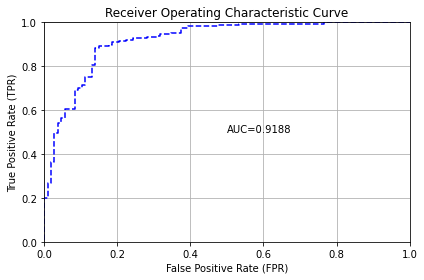

([0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.009345794392523364,
  0.009345794392523364,
  0.009345794392523364,
  0.009345794392523364,
  0.009345794392523364,
  0.009345794392523364,
  0.009345794392523364,
  0.009345794392523364,
  0.009345794392523364,
  0.009345794392523364,
  0.009345794392523364,
  0.009345794392523364,
  0.018691588785046728,
  0.018691588785046728,
  0.018691588785046728,
  0.018691588785046728,
  0.018691588785046728,
  0.018691588785046728,
  0.018691588785046728,
  0.018691588785046728,
  0.018691588785046728,
  0.018691588785046728,
  0.018691588785046728,
  0.018691588785046728,
  0.018691588785046728,
  0.018691588785046728,
  0.018691588785046728,
  0.018691588785046728,
  0.018691588785046728,
  0.028037383177570093,
  0.028037383177570093,
  0.028037383177570093,
 

In [266]:
# Plot ROC Curve
performance = best_xgb.model_performance(test)
performance.plot()

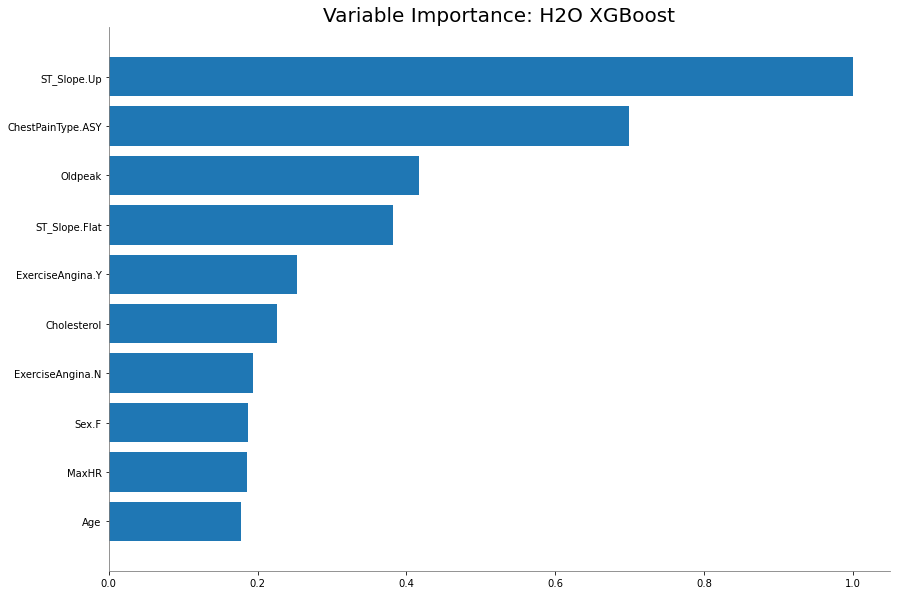

<Figure size 432x288 with 0 Axes>

In [262]:
# Plot Variable Importance for trained XGB, the loaded MOJO doesn't retain variable importance.
# best_xgb.varimp_plot()
best_xgb_temp.varimp_plot()

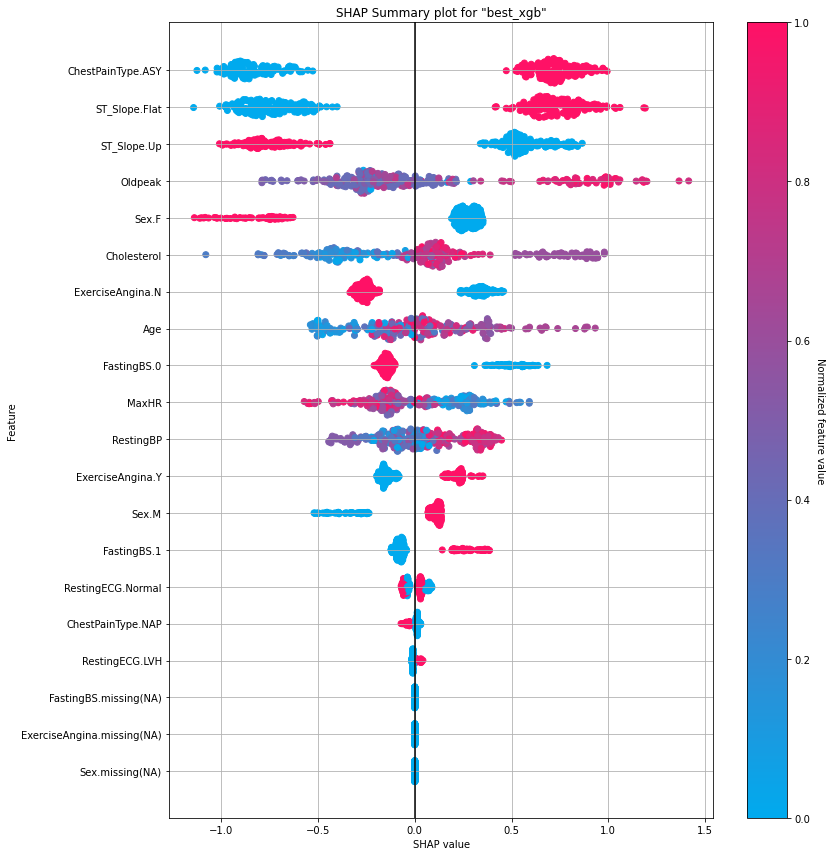

In [263]:
# Plot SHAP summary for the entire test set
best_xgb.shap_summary_plot(test)

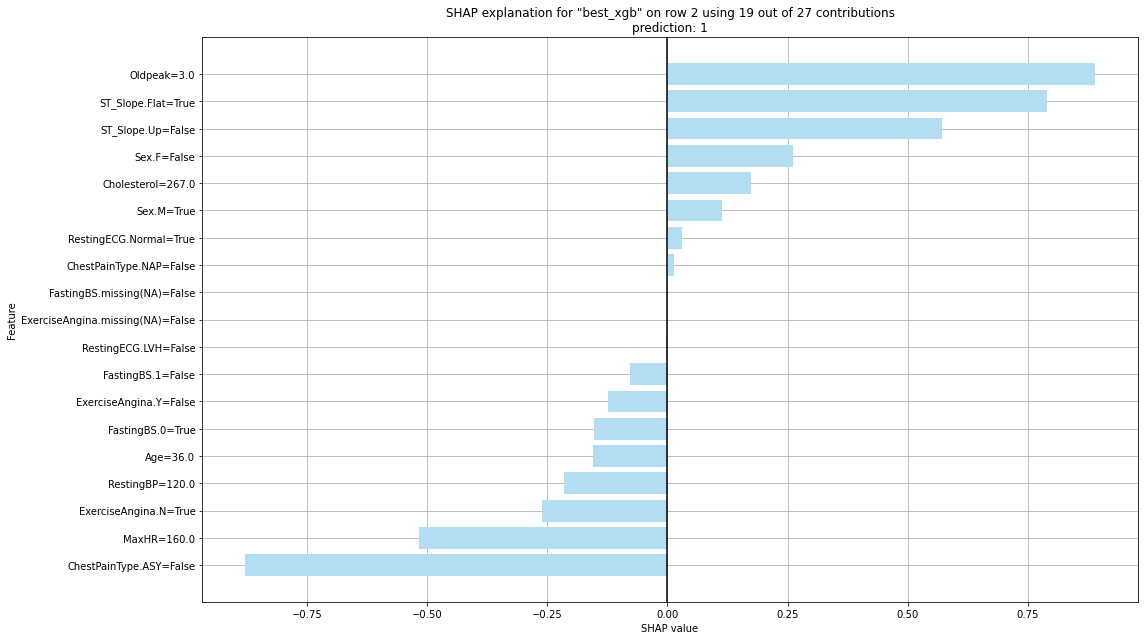

In [264]:
# Isolate prediction and contribution of individual features
shapley_plot = best_xgb.shap_explain_row_plot(test, row_index=2)

In [ ]:
# Shut down h2o
h2o.shutdown()